In [1]:
import flopy
import flopy.mf6 as mf6
import flopy.plot as fplt

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

import cartopy
import cartopy.crs as ccrs
from cartopy.io.img_tiles import GoogleTiles

import findwells as fw

After running the simulation, the outputs are saved to the output files directory. Luckily, you don't need to recreate and run the simulation every time you would like to visualize the outputs. 

Simply load in the simulation and grab the model objects, then retrieve the outputs from the model object!

## Load Simulation

In [2]:
# Load Simulation
sim = mf6.MFSimulation.load(sim_name='peterson', exe_name='../../mf6/mf6.exe', sim_ws='../input-files/')

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package oc...
    loading package sto...
    loading package chd...
    loading package wel...
    loading package obs...
    loading package riv...
    loading package npf...
    loading package ic...
    loading package rch...
  loading model gwt6...
    loading package dis...
    loading package ic...
    loading package adv...
    loading package dsp...
    loading package mst...
    loading package ist...
    loading package cnc...
    loading package ssm...
    loading package obs...
    loading package oc...
  loading model gwt6...
    loading package dis...
    loading package ic...
    loading package adv...
    loading package dsp...
    loading package mst...
    loading package ist...
    loading package cnc...
    loading package ssm...
    loading package obs...
    loading package oc...
  loading model gwt6...
    loading packag

## Load Models

In [3]:
# Grab groundwater flow model from simulation
gwf = sim.get_model('peterson_flow')

# Grab transport model for each solute
gwt_pfos = sim.get_model('peterson_pfos')
gwt_pfoa = sim.get_model('peterson_pfoa')
gwt_pfhxs = sim.get_model('peterson_pfhxs')

## Visualizing Head Data

In [4]:
# read head outputs from model object
head_obj = gwf.output.head()

# Load data from final timestep
heads = head_obj.get_data()

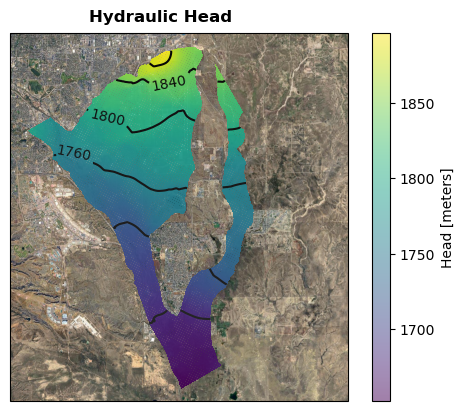

In [5]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.UTM(13)}, layout='constrained', figsize=(6,4), )#dpi=300)

modelmap = fplt.PlotMapView(model=gwf)

vmax = heads[heads!=1e30].max()
vmin = heads[heads!=1e30].min()
cellhead = modelmap.plot_array(heads[0], ax=ax, cmap='viridis', 
                               transform=ccrs.UTM(13), alpha=0.5)
fig.colorbar(cellhead, ax=ax, label='Head [meters]')

contour = modelmap.contour_array(heads[0], ax=ax, vmin=0,
                                 transform=ccrs.UTM(13), cmap='Grays')

ggtiles = GoogleTiles(style='satellite')
ax.add_image(ggtiles, 13)
ax.set_xlabel('Easting [meters]')
ax.set_ylabel('Northing [meters]')
ax.clabel(contour)

plt.suptitle('Hydraulic Head', weight='bold')
plt.show()

## Plot Flooded Cells

In [6]:
# Load in top elevation of layer
top_elev = np.loadtxt('../input-files/data-files/dis-top-elev.dat')

# Take difference between top elevation and head
diff = top_elev - heads[0]
diff_neg = np.where(diff < 0, diff, np.nan)  # Grab negative values (head > top)

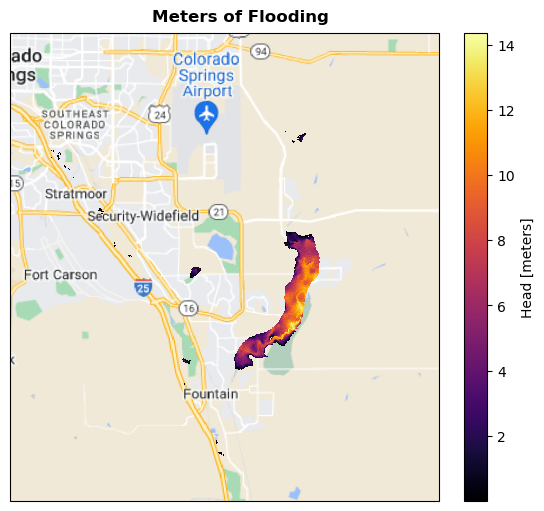

In [7]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.UTM(13)}, layout='constrained', figsize=(6,5))#, dpi=300)

modelmap = fplt.PlotMapView(model=gwf)

cellhead = modelmap.plot_array(-diff_neg, ax=ax, cmap='inferno', transform=ccrs.UTM(13))
fig.colorbar(cellhead, ax=ax, label='Head [meters]')

ggtiles = GoogleTiles()
ax.add_image(ggtiles, 11)
ax.set_xlabel('Easting [meters]')
ax.set_ylabel('Northing [meters]')

plt.suptitle('Meters of Flooding', weight='bold')
# plt.savefig('../figures/flooded-cells.png', bbox_inches='tight')
plt.show()

## Plot Observed vs Simulated Heads

In [8]:
# Read in simulated observations to a dataframe
obs_out = flopy.utils.observationfile.Mf6Obs('../output-files/head_obs.csv', isBinary=False)
sim_df = obs_out.get_dataframe()

In [9]:
# Set time index
sim_df.set_index('totim', inplace=True)
sim_df.head()

# Remove duplicate columns by keeping the first occurrence
sim_df = sim_df.loc[:, ~sim_df.columns.duplicated()]
sim_df.head()

FOUNTAINNO.1  SC01406518ACDT02-MW006  SC01406518CAAMW1-1  \
totim                                                             
59.0    1682.095770             1885.602503         1880.834146   
89.0    1682.037303             1885.603877         1880.837048   
274.0   1681.819638             1885.611099         1880.852793   
304.0   1681.782620             1885.605618         1880.834694   
365.0   1681.730504             1885.597003         1880.804716   

       SC01406519ABDT04-MW004  SC01406519BBBT01-MW002  SC01406520CDBMW2-4  \
totim                                                                       
59.0              1851.626712             1868.301272         1831.626601   
89.0              1851.634727             1868.305754         1831.644315   
274.0             1851.683095             1868.300628         1831.845134   
304.0             1851.602707             1868.244132         1831.827207   
365.0             1851.502707             1868.150082         1831.794083   

       SC01406527ACB1  SC01406527DDB1BANNING-LEWISRANCHES  SC01406527DDB2  \
totim                                                                       
59.0      1819.618822                         1811.985797     1809.927902   
89.0      1819.788112                         1812.103465     1810.083380   
274.0     1819.838337                         1812.469694     1810.575115   
304.0     1819.841173                         1812.519291     1810.643983   
365.0     1819.842337                         1812.578286     1810.739135   

       SC01406527DDC1  ...  SCO1506602BBBTH-18  SCO1506602BDC  SCO1506602CAA  \
totim                  ...                                                     
59.0      1807.807756  ...         1775.490955    1766.954843    1765.759536   
89.0      1807.936349  ...         1775.499943    1766.961697    1765.761105   
274.0     1808.453042  ...         1775.266181    1766.909296    1765.748623   
304.0     1808.528423  ...         1775.171562    1766.873554    1765.742017   
365.0     1808.640865  ...         1774.991338    1766.775849    1765.700471   

       SCO1506603AAD  SCO1506603BAC  SCO1506604AAA  SCO1506604AABTH-49  \
totim                                                                    
59.0     1769.243578    1761.974481    1763.998712         1762.174199   
89.0     1769.257285    1761.949220    1763.802846         1762.487046   
274.0    1769.146590    1761.657947    1763.424829         1762.409145   
304.0    1769.069728    1761.606366    1763.365839         1762.394681   
365.0    1768.931044    1761.490158    1763.303340         1762.379454   

       SCO1506604ABA2TH-50  SCO1506610BAA  SCO1506611ABCTH-47  
totim                                                          
59.0           1762.212883    1749.557095         1748.993811  
89.0           1762.563661    1749.557666         1748.993770  
274.0          1762.512399    1749.559561         1748.994801  
304.0          1762.502547    1749.556319         1748.994867  
365.0          1762.492188    1749.552055         1748.993754  

[5 rows x 149 columns]

In [10]:
obs_df = pd.read_csv('../input-files/data-files/flow-observed-heads.csv', index_col='time')
obs_df.head()

FOUNTAINNO.1  SC01406518ACDT02-MW006  SC01406518CAAMW1-1  \
time                                                             
59             NaN                     NaN                 NaN   
89             NaN                     NaN                 NaN   
454            NaN                     NaN                 NaN   
639            NaN                     NaN                 NaN   
789            NaN                     NaN                 NaN   

      SC01406519ABDT04-MW004  SC01406519BBBT01-MW002  SC01406520CDBMW2-4  \
time                                                                       
59                       NaN                     NaN                 NaN   
89                       NaN                     NaN                 NaN   
454                      NaN                     NaN                 NaN   
639                      NaN                     NaN                 NaN   
789                      NaN                     NaN                 NaN   

      SC01406527ACB1  SC01406527DDB1BANNING-LEWISRANCHES  SC01406527DDB2  \
time                                                                       
59               NaN                                 NaN             NaN   
89               NaN                                 NaN             NaN   
454              NaN                                 NaN             NaN   
639              NaN                                 NaN             NaN   
789              NaN                                 NaN     1802.757888   

      SC01406527DDC1  ...  SCO1506602BBBTH-18  SCO1506602BDC  SCO1506602CAA  \
time                  ...                                                     
59               NaN  ...                 NaN            NaN            NaN   
89               NaN  ...                 NaN            NaN            NaN   
454              NaN  ...                 NaN            NaN            NaN   
639              NaN  ...                 NaN            NaN            NaN   
789      1803.123648  ...                 NaN            NaN            NaN   

      SCO1506603AAD  SCO1506603BAC  SCO1506604AAA  SCO1506604AABTH-49  \
time                                                                    
59              NaN            NaN            NaN                 NaN   
89              NaN            NaN            NaN                 NaN   
454             NaN            NaN            NaN                 NaN   
639             NaN            NaN            NaN                 NaN   
789             NaN            NaN            NaN                 NaN   

      SCO1506604ABA2TH-50  SCO1506610BAA  SCO1506611ABCTH-47  
time                                                          
59                    NaN            NaN                 NaN  
89                    NaN            NaN                 NaN  
454                   NaN            NaN                 NaN  
639                   NaN            NaN                 NaN  
789                   NaN            NaN                 NaN  

[5 rows x 149 columns]

In [11]:
# Align sim_df and obs_df by their common indices
common_index = sim_df.index.intersection(obs_df.index)

# Use only the rows corresponding to the common index
sim_df_aligned = sim_df.loc[common_index]
obs_df_aligned = obs_df.loc[common_index]

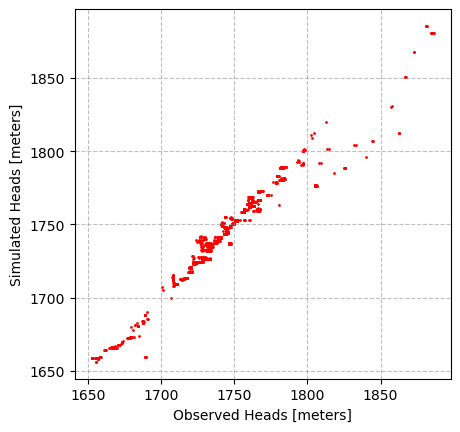

In [12]:
fig, ax = plt.subplots()

for col in sim_df.columns:
    if (col != 'SC01506614BBA TH-5') & (col != 'SC01606516CCC2'):
        ax.scatter(obs_df_aligned[col], sim_df_aligned[col], color='r', s=1)

    else:
        print(f"Well {col} not in both")

ax.set_xlabel('Observed Heads [meters]')
ax.set_ylabel('Simulated Heads [meters]')
ax.set_aspect('equal')
ax.grid(ls='--', color='gray', alpha=0.5)

## Plot Concentration Results

### PFOS Results

In [4]:
# Get solute concentrations
PFOS = gwt_pfos.output.concentration().get_alldata()
PFOA = gwt_pfoa.output.concentration().get_alldata()
PFHxS = gwt_pfhxs.output.concentration().get_alldata()

In [5]:
PFOS.shape, PFOA.shape, PFHxS.shape

((104, 1, 972, 700), (104, 1, 972, 700), (104, 1, 972, 700))

In [19]:
downstream_wells = pd.read_csv('../input-files/data-files/tran-targets-downstream.csv')
upstream_well = pd.read_excel('../input-files/data-files/tran-PFAS-targets.xlsx', sheet_name='PFOS')

In [24]:
x = gwt_pfos.modelgrid.xcellcenters[downstream_wells['x'].to_numpy('int64'), downstream_wells['y'].to_numpy('int64')]
y = gwt_pfos.modelgrid.ycellcenters[downstream_wells['x'].to_numpy('int64'), downstream_wells['y'].to_numpy('int64')]

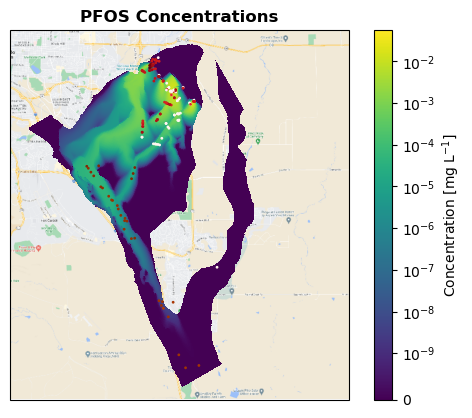

In [25]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.UTM(13)})

modelmap = fplt.PlotMapView(model=gwt_pfos)

vmax = PFOS[PFOS != 1e30].max()
norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
cs1 = modelmap.plot_array(PFOS[-1], transform=ccrs.UTM(13), norm=norm)
fig.colorbar(cs1, ax=ax, label="Concentration [mg L$^{-1}$]")

ax.scatter(upstream_well['x'], upstream_well['y'], label=upstream_well['Well_ID'], transform=ccrs.PlateCarree(), c=upstream_well['Result_ngL'], s=1, cmap='Reds', norm=SymLogNorm(linthresh=1e-9, vmin=0))

ax.scatter(x, y, c=downstream_wells['PFOS (ng/L)'], transform=ccrs.UTM(13), cmap='Oranges', norm=SymLogNorm(linthresh=1e-9, vmin=0), s=1)



ggtiles = GoogleTiles()
ax.add_image(ggtiles, 13)
ax.set_title('PFOS Concentrations', weight='bold')

plt.show()

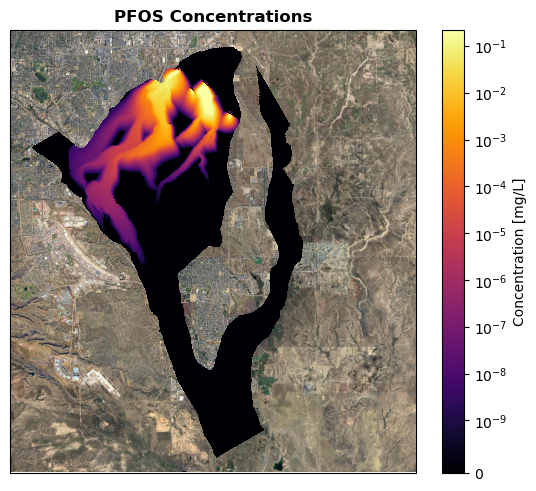

In [6]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.UTM(13)}, layout='constrained',)# figsize=(18, 5))

modelmap = fplt.PlotMapView(model=gwt_pfos)

# plot PFOS
vmax = PFOS[PFOS != 1e30].max()
norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
conc = modelmap.plot_array(PFOS[-1], ax=ax, cmap='inferno', norm=norm,
                               transform=ccrs.UTM(13))
fig.colorbar(conc, ax=ax, label='Concentration [mg/L]')

ggtiles = GoogleTiles(style='satellite')
ax.add_image(ggtiles, 13)
ax.set_title('PFOS Concentrations', weight='bold')

plt.show()

### Observed vs Simulated PFOS concentration

Day of sampling since model start: `17713`

In [7]:
# Read in simulated observations to a dataframe
obs_out = flopy.utils.observationfile.Mf6Obs('../output-files/pfos_obs.csv', isBinary=False)
sim_wells = obs_out.get_dataframe()

closest_index = sim_wells.index[(np.abs(sim_wells.totim - 17713)).argmin()]
sim_results = sim_wells.loc[closest_index]

In [8]:
obs_wells = pd.read_csv('../input-files/data-files/tran-targets-downstream.csv', index_col='Well Name')
obs_wells = obs_wells.T

In [9]:
common_index = obs_wells.columns.intersection(sim_results.index)

sim_results = sim_results.loc[common_index] * 1e6
obs_results = obs_wells.T.loc[common_index, "PFOS (ng/L)"]

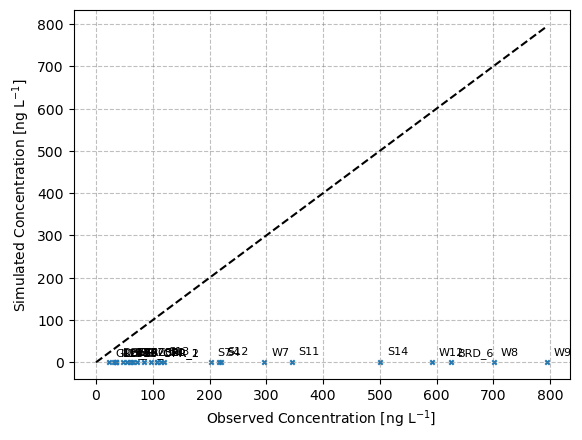

In [10]:
obs = obs_results.to_numpy(dtype='float64')
sim = sim_results.to_numpy(dtype='float64')

names = obs_results.index  # Adjust this if names are in a specific column, e.g., obs_results['Name']

vmin = min(obs.min(), sim.min())
vmin = min(obs.min(), sim.min())
vmax = max(obs.max(), sim.max())
xy = np.linspace(vmin, vmax, 10)

fig, ax = plt.subplots()

ax.scatter(obs, sim, s=10, marker='x')
ax.plot(xy, xy, linestyle='--', c='k')
ax.grid(ls='--', color='grey', alpha=0.5)

ax.set_xlabel('Observed Concentration [ng L$^{-1}$]')
ax.set_ylabel('Simulated Concentration [ng L$^{-1}$]')

# Add labels for each point
for i, name in enumerate(names):
    ax.annotate(name, (obs[i], sim[i]), fontsize=8, xytext=(5, 5), textcoords='offset points')

plt.show()

In [11]:
pfos_us = pd.read_csv('../input-files/data-files/tran-PFOS-observations.csv')

In [12]:
pfos_us['SDate'] = pd.to_datetime(pfos_us.SDate)

In [13]:
pfos_us.set_index('SDate', inplace=True)

In [14]:
obs_out = flopy.utils.observationfile.Mf6Obs('../output-files/pfos_obs.csv', isBinary=False)
sim_wells = obs_out.get_dataframe()

In [15]:
# closest_index = sim_wells.index[(np.abs(sim_wells.totim - 17713)).argmin()]

closest_rows = []
for date in pfos_us.index:
    # Find the closest index in the reshaped DataFrame
    closest_index = sim_wells.index[(np.abs(sim_wells.index - date)).argmin()]
    
    # Store the closest date and row values
    closest_rows.append(closest_index)

In [16]:
sim_wells_aligned = sim_wells.loc[closest_rows]
sim_wells_aligned.drop(columns='totim', axis=1, inplace=True)

Well BRD_6 not in both
Well 11960_OPR_2 not in both
Well 12425_OPR_1 not in both
Well DLE not in both
Well GLD_3 not in both
Well ING_2 not in both
Well IRIS_3 not in both
Well WELL-1 not in both
Well WELL-3 not in both
Well WELL-4 not in both
Well FV4 not in both
Well R1 not in both
Well R2 not in both
Well S2 not in both
Well S4 not in both
Well S7 not in both
Well S9 not in both
Well S10 not in both
Well S11 not in both
Well S12 not in both
Well S13 not in both
Well S14 not in both
Well S15 not in both
Well S16 not in both
Well S17 not in both
Well W8 not in both
Well W9 not in both
Well W12 not in both
Well C2 not in both
Well C36 not in both
Well W7 not in both
Well MW1-2_1 not in both
Well PETER-T13-MW006_1 not in both


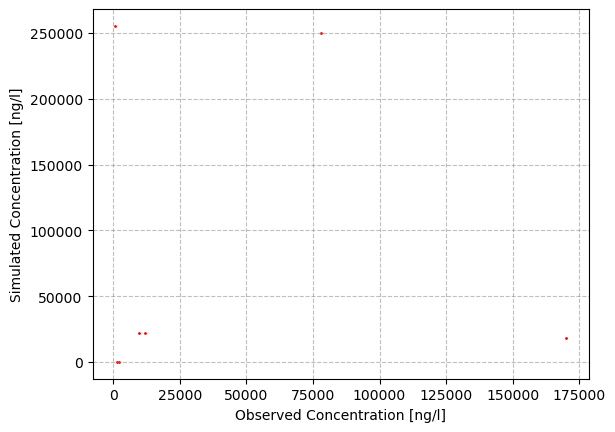

In [17]:
fig, ax = plt.subplots()

for col in sim_wells_aligned.columns:
    try:
        ax.scatter(pfos_us[col], sim_wells_aligned[col] * 1e6, color='r', s=1)
        well_names = pfos_us.columns  # Extract well names from the column headers
        
    except:
        print(f"Well {col} not in both")

#ax.set_xscale('log')  # Log scale for the x-axis

ax.set_xlabel('Observed Concentration [ng/l]')
ax.set_ylabel('Simulated Concentration [ng/l]')
# ax.set_aspect('equal')
ax.grid(ls='--', color='gray', alpha=0.5)

### PFOA Results

In [38]:
PFOA.shape

(446, 1, 972, 700)

In [39]:
downstream_wells = pd.read_csv('../input-files/data-files/tran-targets-downstream.csv')
upstream_well = pd.read_excel('../input-files/data-files/tran-PFAS-targets.xlsx', sheet_name='PFOA')

In [41]:
x = gwt_pfos.modelgrid.xcellcenters[downstream_wells['x'].to_numpy('int64'), downstream_wells['y'].to_numpy('int64')]
y = gwt_pfos.modelgrid.ycellcenters[downstream_wells['x'].to_numpy('int64'), downstream_wells['y'].to_numpy('int64')]

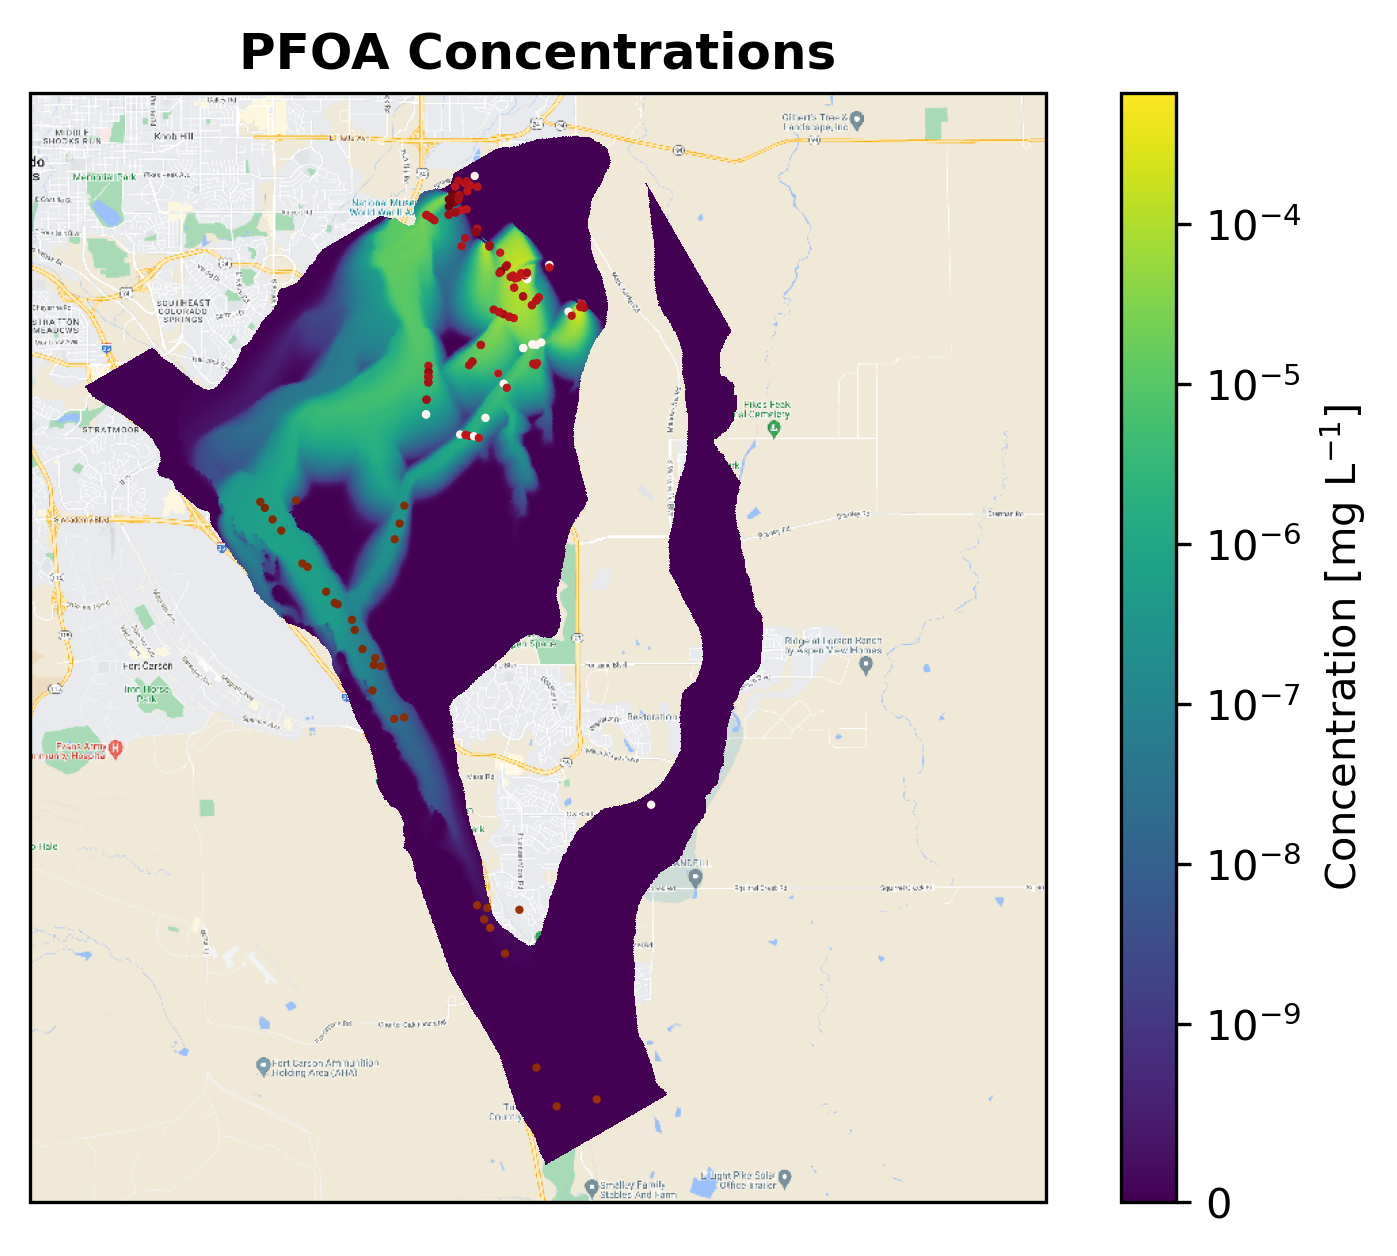

In [42]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.UTM(13)}, dpi=300)

modelmap = fplt.PlotMapView(model=gwt_pfoa)

vmax = PFOA[PFOA != 1e30].max()
norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
cs1 = modelmap.plot_array(PFOA[-1], transform=ccrs.UTM(13), norm=norm)
fig.colorbar(cs1, ax=ax, label="Concentration [mg L$^{-1}$]")

ax.scatter(upstream_well['x'], upstream_well['y'], label=upstream_well['Well_ID'], transform=ccrs.PlateCarree(), c=upstream_well['Result_ngL'], s=1, cmap='Reds', norm=SymLogNorm(linthresh=1e-9, vmin=0))

ax.scatter(x, y, c=downstream_wells['PFOA (ng/L)'], transform=ccrs.UTM(13), cmap='Oranges', norm=SymLogNorm(linthresh=1e-9, vmin=0), s=1)


ggtiles = GoogleTiles()
ax.add_image(ggtiles, 13)
ax.set_title('PFOA Concentrations', weight='bold')

plt.show()

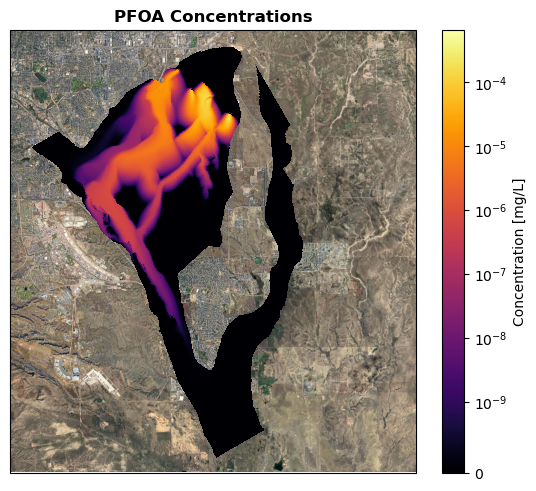

In [43]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.UTM(13)}, layout='constrained',)# figsize=(18, 5))

modelmap = fplt.PlotMapView(model=gwt_pfos)

# plot PFOA
vmax = PFOA[PFOA != 1e30].max()
norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
conc = modelmap.plot_array(PFOA[-1], ax=ax, cmap='inferno', norm=norm,
                               transform=ccrs.UTM(13))
fig.colorbar(conc, ax=ax, label='Concentration [mg/L]')

ggtiles = GoogleTiles(style='satellite')
ax.add_image(ggtiles, 13)
ax.set_title('PFOA Concentrations', weight='bold')

plt.show()

### Observed vs Simulated PFOA concentration

In [44]:
# Read in simulated observations to a dataframe
obs_out = flopy.utils.observationfile.Mf6Obs('../output-files/pfoa_obs.csv', isBinary=False)
sim_wells = obs_out.get_dataframe()

closest_index = sim_wells.index[(np.abs(sim_wells.totim - 17713)).argmin()]
sim_results = sim_wells.loc[closest_index]

In [45]:
common_index = obs_wells.columns.intersection(sim_results.index)

sim_results = sim_results.loc[common_index] * 1e6
obs_results = obs_wells.T.loc[common_index, "PFOA (ng/L)"]

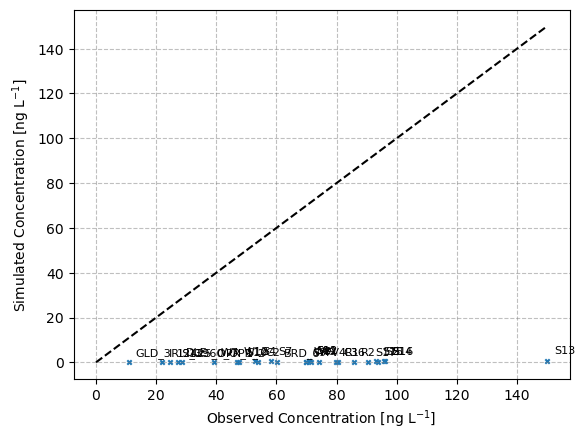

In [46]:
obs = obs_results.to_numpy(dtype='float64')
sim = sim_results.to_numpy(dtype='float64')

names = obs_results.index  # Adjust this if names are in a specific column, e.g., obs_results['Name']

vmin = min(obs.min(), sim.min())
vmax = max(obs.max(), sim.max())
xy = np.linspace(vmin, vmax, 10)

fig, ax = plt.subplots()

ax.scatter(obs, sim, marker='x', s=10)
ax.plot(xy, xy, linestyle='--', c='k')
ax.grid(ls='--', color='grey', alpha=0.5)

ax.set_xlabel('Observed Concentration [ng L$^{-1}$]')
ax.set_ylabel('Simulated Concentration [ng L$^{-1}$]')

# Add labels for each point
for i, name in enumerate(names):
    ax.annotate(name, (obs[i], sim[i]), fontsize=8, xytext=(5, 5), textcoords='offset points')

plt.show()

In [48]:
pfoa_us = pd.read_csv('../input-files/data-files/tran-PFOA-observations.csv')

pfoa_us['SDate'] = pd.to_datetime(pfoa_us.SDate)

pfoa_us.set_index('SDate', inplace=True)

In [49]:
# Not confident this cell needs to be in again
obs_out = flopy.utils.observationfile.Mf6Obs('../output-files/pfoa_obs.csv', isBinary=False)
sim_wells = obs_out.get_dataframe()

In [50]:
# closest_index = sim_wells.index[(np.abs(sim_wells.totim - 17713)).argmin()]

closest_rows = []
for date in pfos_us.index:
    # Find the closest index in the reshaped DataFrame
    closest_index = sim_wells.index[(np.abs(sim_wells.index - date)).argmin()]
    
    # Store the closest date and row values
    closest_rows.append(closest_index)

In [51]:
sim_wells_aligned = sim_wells.loc[closest_rows]
sim_wells_aligned.drop(columns='totim', axis=1, inplace=True)

Well BRD_6 not in both
Well 11960_OPR_2 not in both
Well 12425_OPR_1 not in both
Well DLE not in both
Well GLD_3 not in both
Well ING_2 not in both
Well IRIS_3 not in both
Well WELL-1 not in both
Well WELL-3 not in both
Well WELL-4 not in both
Well FV4 not in both
Well R1 not in both
Well R2 not in both
Well S2 not in both
Well S4 not in both
Well S7 not in both
Well S9 not in both
Well S10 not in both
Well S11 not in both
Well S12 not in both
Well S13 not in both
Well S14 not in both
Well S15 not in both
Well S16 not in both
Well S17 not in both
Well W8 not in both
Well W9 not in both
Well W12 not in both
Well C2 not in both
Well C36 not in both
Well W7 not in both
Well DEICEPONDSNORTH not in both
Well DEICEPONDSNORTH_1 not in both
Well DEICEPONDSSOUTH not in both
Well MW1-2_1 not in both
Well MW2-1_1 not in both
Well MW2-2_1 not in both
Well MW2-3_1 not in both
Well MW2-3_2 not in both
Well MW2-3_3 not in both
Well MW2-4_1 not in both
Well MW2-4_2 not in both
Well MW4-1_1 not in both

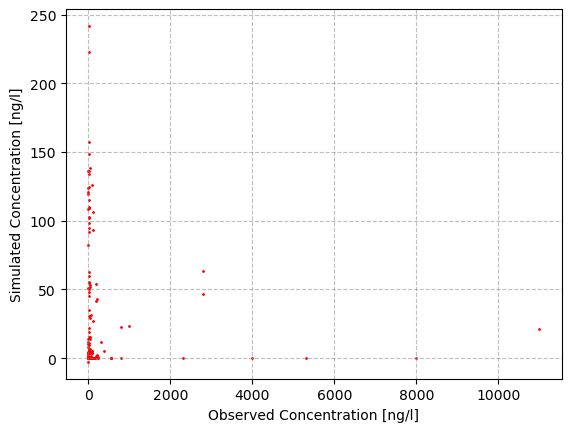

In [52]:
fig, ax = plt.subplots()

for col in sim_wells_aligned.columns:
    try:
        ax.scatter(pfoa_us[col], sim_wells_aligned[col] * 1e6, color='r', s=1)

    except:
        print(f"Well {col} not in both")

#ax.set_xscale('log')  # Log scale for the x-axis

ax.set_xlabel('Observed Concentration [ng/l]')
ax.set_ylabel('Simulated Concentration [ng/l]')
# ax.set_aspect('equal')
ax.grid(ls='--', color='gray', alpha=0.5)

### PFHxS Results

In [53]:
PFHxS.shape

(446, 1, 972, 700)

In [54]:
downstream_wells = pd.read_csv('../input-files/data-files/tran-targets-downstream.csv')
upstream_well = pd.read_excel('../input-files/data-files/tran-PFAS-targets.xlsx', sheet_name='PFHxS')

In [56]:
x = gwt_pfhxs.modelgrid.xcellcenters[downstream_wells['x'].to_numpy('int64'), downstream_wells['y'].to_numpy('int64')]
y = gwt_pfhxs.modelgrid.ycellcenters[downstream_wells['x'].to_numpy('int64'), downstream_wells['y'].to_numpy('int64')]

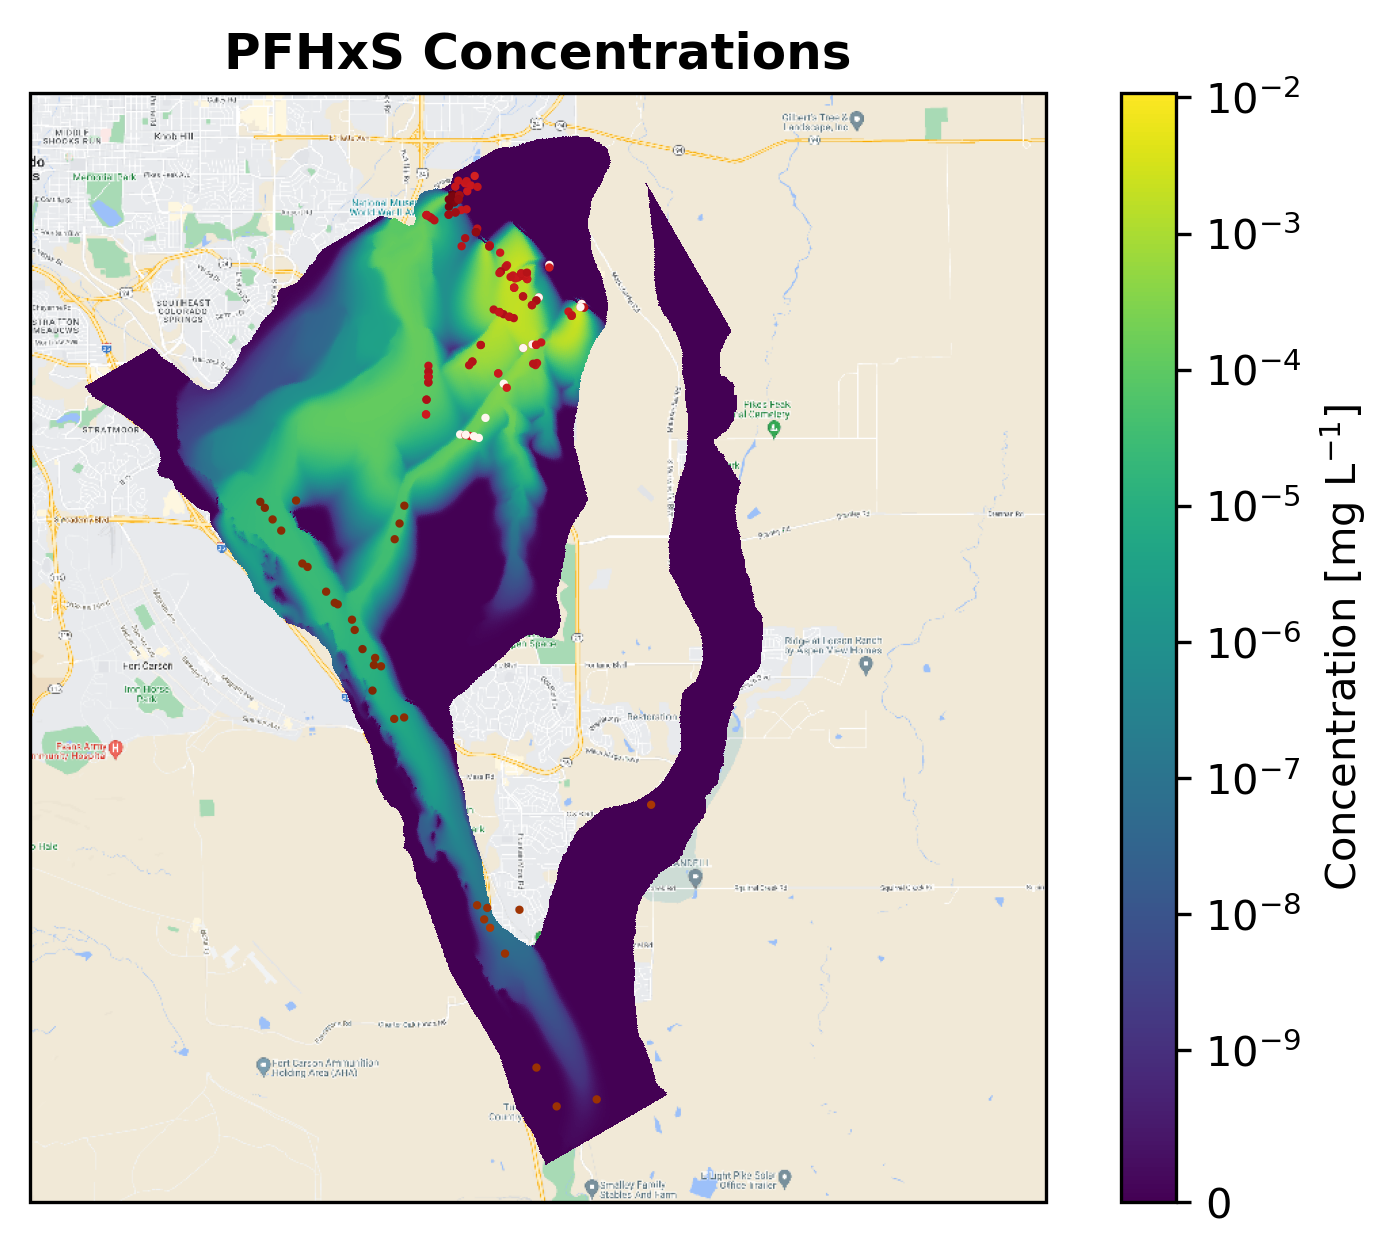

In [57]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.UTM(13)}, dpi=300)

modelmap = fplt.PlotMapView(model=gwt_pfos)

vmax = PFHxS[PFHxS != 1e30].max()
norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
cs1 = modelmap.plot_array(PFHxS[-1], transform=ccrs.UTM(13), norm=norm)
fig.colorbar(cs1, ax=ax, label="Concentration [mg L$^{-1}$]")

# cs1 = modelmap.plot_array(k, transform=ccrs.UTM(13))
# fig.colorbar(cs1, ax=ax, label="Concentration [mg L$^{-1}$]")

ax.scatter(upstream_well['x'], upstream_well['y'], label=upstream_well['Well_ID'], transform=ccrs.PlateCarree(), c=upstream_well['Result_ngL'], s=1, cmap='Reds', norm=SymLogNorm(linthresh=1e-9, vmin=0))

ax.scatter(x, y, c=downstream_wells['PFHxS (ng/L)'], transform=ccrs.UTM(13), cmap='Oranges', norm=SymLogNorm(linthresh=1e-9, vmin=0), s=1)


ggtiles = GoogleTiles()
ax.add_image(ggtiles, 13)
ax.set_title('PFHxS Concentrations', weight='bold')

plt.show()

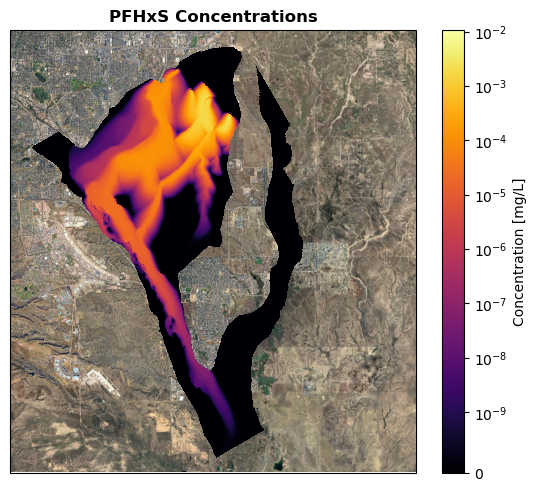

In [58]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.UTM(13)}, layout='constrained',)# figsize=(18, 5))

modelmap = fplt.PlotMapView(model=gwt_pfhxs)

# plot PFOS
vmax = PFHxS[PFHxS != 1e30].max()
norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
conc = modelmap.plot_array(PFHxS[-1], ax=ax, cmap='inferno', norm=norm,
                               transform=ccrs.UTM(13))
fig.colorbar(conc, ax=ax, label='Concentration [mg/L]')

ggtiles = GoogleTiles(style='satellite')
ax.add_image(ggtiles, 13)
ax.set_title('PFHxS Concentrations', weight='bold')

plt.show()

### Observed vs Simulated PFHxS concentration

In [59]:
# Read in simulated observations to a dataframe
obs_out = flopy.utils.observationfile.Mf6Obs('../output-files/pfhxs_obs.csv', isBinary=False)
sim_wells = obs_out.get_dataframe()

closest_index = sim_wells.index[(np.abs(sim_wells.totim - 17713)).argmin()]
sim_results = sim_wells.loc[closest_index]

In [60]:
common_index = obs_wells.columns.intersection(sim_results.index)

sim_results = sim_results.loc[common_index] * 1e6
obs_results = obs_wells.T.loc[common_index, "PFHxS (ng/L)"]

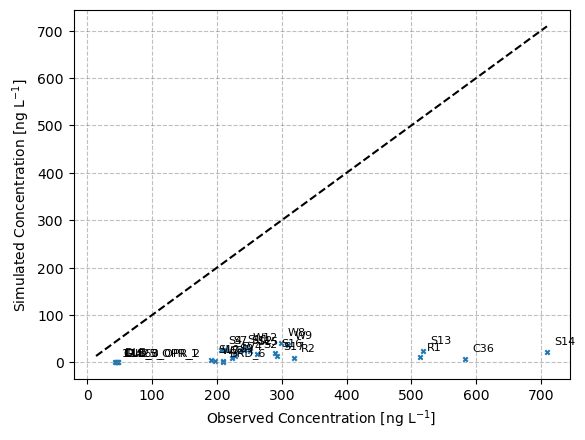

In [61]:
obs = obs_results.to_numpy(dtype='float64')
sim = sim_results.to_numpy(dtype='float64')

names = obs_results.index  # Adjust this if names are in a specific column, e.g., obs_results['Name']

vmin = min(obs.min(), sim.min())
vmax = max(obs.max(), sim.max())
xy = np.linspace(vmin, vmax, 10)

fig, ax = plt.subplots()

ax.scatter(obs, sim, s=10, marker='x')
ax.plot(xy, xy, linestyle='--', c='k')
ax.grid(ls='--', color='grey', alpha=0.5)

ax.set_xlabel('Observed Concentration [ng L$^{-1}$]')
ax.set_ylabel('Simulated Concentration [ng L$^{-1}$]')

# Add labels for each point
for i, name in enumerate(names):
    ax.annotate(name, (obs[i], sim[i]), fontsize=8, xytext=(5, 5), textcoords='offset points')

plt.show()

In [62]:
pfhxs_us = pd.read_csv('../input-files/data-files/tran-PFHxS-observations.csv')

pfhxs_us['SDate'] = pd.to_datetime(pfhxs_us.SDate)

pfhxs_us.set_index('SDate', inplace=True)

In [56]:
obs_out = flopy.utils.observationfile.Mf6Obs('../output-files/pfhxs_obs.csv', isBinary=False)
sim_wells = obs_out.get_dataframe()

In [57]:
# closest_index = sim_wells.index[(np.abs(sim_wells.totim - 17713)).argmin()]

closest_rows = []
for date in pfos_us.index:
    # Find the closest index in the reshaped DataFrame
    closest_index = sim_wells.index[(np.abs(sim_wells.index - date)).argmin()]
    
    # Store the closest date and row values
    closest_rows.append(closest_index)

In [58]:
sim_wells_aligned = sim_wells.loc[closest_rows]
sim_wells_aligned.drop(columns='totim', axis=1, inplace=True)

Well BRD_6 not in both
Well 11960_OPR_2 not in both
Well 12425_OPR_1 not in both
Well DLE not in both
Well GLD_3 not in both
Well ING_2 not in both
Well IRIS_3 not in both
Well WELL 1 not in both
Well WELL 3 not in both
Well WELL 4 not in both
Well FV4 not in both
Well R1 not in both
Well R2 not in both
Well S2 not in both
Well S4 not in both
Well S7 not in both
Well S9 not in both
Well S10 not in both
Well S11 not in both
Well S12 not in both
Well S13 not in both
Well S14 not in both
Well S15 not in both
Well S16 not in both
Well S17 not in both
Well W8 not in both
Well W9 not in both
Well W12 not in both
Well C2 not in both
Well C36 not in both
Well W7 not in both
Well DEICEPONDSNORTH not in both
Well DEICEPONDSNORTH_1 not in both
Well DEICEPONDSSOUTH not in both
Well MW1-2_1 not in both
Well MW2-1_1 not in both
Well MW2-2_1 not in both
Well MW2-3_1 not in both
Well MW2-3_2 not in both
Well MW2-3_3 not in both
Well MW2-4_1 not in both
Well MW2-4_2 not in both
Well MW4-1_1 not in both

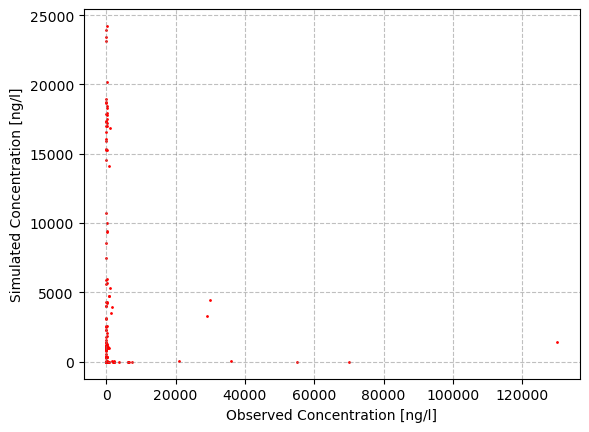

In [59]:
fig, ax = plt.subplots()

for col in sim_wells_aligned.columns:
    try:
        ax.scatter(pfhxs_us[col], sim_wells_aligned[col] * 1e6, color='r', s=1)

    except:
        print(f"Well {col} not in both")

#ax.set_xscale('log')  # Log scale for the x-axis

ax.set_xlabel('Observed Concentration [ng/l]')
ax.set_ylabel('Simulated Concentration [ng/l]')
# ax.set_aspect('equal')
ax.grid(ls='--', color='gray', alpha=0.5)

In [60]:
import imageio

In [78]:
# fig, axs = plt.subplots(ncols=3, subplot_kw={'projection':ccrs.UTM(13)}, layout='constrained', figsize=(18, 5))
# ax1, ax2, ax3 = axs

# modelmap = fplt.PlotMapView(model=gwt_pfos)

# # plot PFOS
# vmax = PFOS[PFOS != 1e30].max()
# norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
# cellhead = modelmap.plot_array(PFOS[0], ax=ax1, cmap='inferno', norm=norm,
#                                transform=ccrs.UTM(13))
# fig.colorbar(cellhead, ax=ax1, label='Concentration [mg/L]')

# # Plot PFOA
# vmax = PFOA[PFOA != 1e30].max()
# norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
# cellhead = modelmap.plot_array(PFOA[0], ax=ax2, cmap='inferno', norm=norm, 
#                                transform=ccrs.UTM(13))
# fig.colorbar(cellhead, ax=ax2, label='Concentration [mg/L]')

# # Plot PFHxS
# vmax = PFHxS[PFHxS != 1e30].max()
# norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
# cellhead = modelmap.plot_array(PFHxS[0], ax=ax3, cmap='inferno', norm=norm, 
#                                transform=ccrs.UTM(13))
# fig.colorbar(cellhead, ax=ax3, label='Concentration [mg/L]')

# titles = ['PFOS Concentrations', 'PFOA Concentrations', 'PFHxS Concentrations']
# for ax, title in zip(axs, titles):
#     ggtiles = GoogleTiles(style='satellite')
#     ax.add_image(ggtiles, 13)
    
#     ax.set_title(title, weight='bold')

# plt.show()

In [ ]:
# for i in range(350):
#     fig, axs = plt.subplots(ncols=3, subplot_kw={'projection':ccrs.UTM(13)}, layout='constrained', figsize=(18, 5))
#     ax1, ax2, ax3 = axs
    
#     modelmap = fplt.PlotMapView(model=gwt_pfos)
    
#     # plot PFOS
#     vmax = PFOS[PFOS != 1e30].max()
#     norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
#     cellhead = modelmap.plot_array(PFOS[i][0], ax=ax1, cmap='inferno', norm=norm,
#                                    transform=ccrs.UTM(13))
#     fig.colorbar(cellhead, ax=ax1, label='Concentration [mg/L]')
    
#     # Plot PFOA
#     vmax = PFOA[PFOA != 1e30].max()
#     norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
#     cellhead = modelmap.plot_array(PFOA[i][0], ax=ax2, cmap='inferno', norm=norm, 
#                                    transform=ccrs.UTM(13))
#     fig.colorbar(cellhead, ax=ax2, label='Concentration [mg/L]')
    
#     # Plot PFHxS
#     vmax = PFHxS[PFHxS != 1e30].max()
#     norm = SymLogNorm(1e-9, vmin=0, vmax=vmax)
#     cellhead = modelmap.plot_array(PFHxS[i][0], ax=ax3, cmap='inferno', norm=norm, 
#                                    transform=ccrs.UTM(13))
#     fig.colorbar(cellhead, ax=ax3, label='Concentration [mg/L]')
    
#     titles = ['PFOS Concentrations', 'PFOA Concentrations', 'PFHxS Concentrations']
#     for ax, title in zip(axs, titles):
#         ggtiles = GoogleTiles(style='satellite')
#         ax.add_image(ggtiles, 13)
        
#         ax.set_title(title, weight='bold')
    
#     plt.savefig(f'../figures/gif-pngs/sp-{i}.png')
#     plt.close()

# pngs = [imageio.v2.imread(f'../figures/gif-pngs/sp-{i}.png') for i in range(350)]

# imageio.mimsave('../figures/concentrations.gif', pngs, duration=50, loop=0)

## Well Breakthrough Curves

In [6]:
upstream = pd.read_excel('../input-files/data-files/tran-PFAS-targets.xlsx')
downstream = pd.read_csv('../input-files/data-files/tran-targets-downstream.csv')

In [7]:
pfos_wells.loc[:, ['W8', 'W9', 'W12','S17']]

W8        W9       W12       S17
time                                           
59.0     0.000000  0.000000  0.000000  0.000000
89.0     0.000000  0.000000  0.000000  0.000000
274.0    0.000000  0.000000  0.000000  0.000000
304.0    0.000000  0.000000  0.000000  0.000000
365.0    0.000000  0.000000  0.000000  0.000000
...           ...       ...       ...       ...
18139.0  0.000165  0.000131  0.000107  0.000029
18169.0  0.000168  0.000133  0.000109  0.000030
18200.0  0.000171  0.000136  0.000111  0.000030
18230.0  0.000174  0.000138  0.000113  0.000031
18262.0  0.000177  0.000141  0.000116  0.000031

[446 rows x 4 columns]

In [8]:
import matplotlib.dates as mdates
from datetime import datetime, timedelta

In [9]:
observations_pfos = pd.read_csv('../input-files/data-files/tran-PFOS-observations.csv')

In [10]:
observations_pfos['SDate'] = pd.to_datetime(observations_pfos['SDate'])

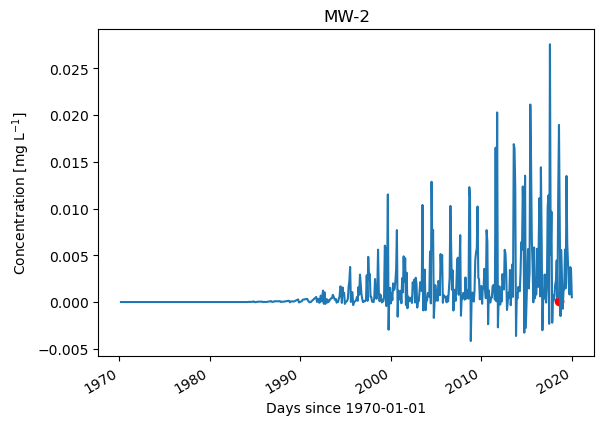

In [11]:
fig, ax = plt.subplots()

convertible_indexes = pfos_wells.index[pfos_wells['MW-2'].apply(is_convertible_to_float)].to_numpy()
well = pfos_wells.loc[convertible_indexes, 'MW-2'].to_numpy('float64')

# Convert x-axis values (convertible_indexes) to datetime
start_date = datetime(1970, 1, 1)
date_indexes = [start_date + timedelta(days=int(x)) for x in convertible_indexes]

ax.scatter(observations_pfos.SDate, observations_pfos['MW-2'] * 1e-9, c='r')
ax.plot(date_indexes, well)#, label=column)
ax.set_ylabel('Concentration [mg L$^{-1}$]')
ax.set_xlabel('Days since 1970-01-01')
ax.set_title('MW-2')



# Format x-axis as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format the x-axis with dates
fig.autofmt_xdate()  # Rotate date labels for better readability

# ax.legend()
    
plt.show()

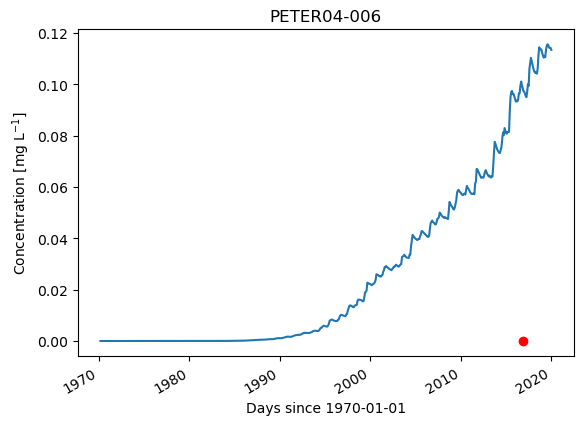

In [12]:
fig, ax = plt.subplots()

convertible_indexes = pfos_wells.index[pfos_wells['PETER04-006'].apply(is_convertible_to_float)].to_numpy()
well = pfos_wells.loc[convertible_indexes, 'PETER04-006'].to_numpy('float64')

# Convert x-axis values (convertible_indexes) to datetime
start_date = datetime(1970, 1, 1)
date_indexes = [start_date + timedelta(days=int(x)) for x in convertible_indexes]

ax.scatter(observations_pfos.SDate, observations_pfos['PETER04-006'] * 1e-9, c='r')
ax.plot(date_indexes, well)#, label=column)
ax.set_ylabel('Concentration [mg L$^{-1}$]')
ax.set_xlabel('Days since 1970-01-01')

ax.set_title('PETER04-006')
# Format x-axis as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format the x-axis with dates
fig.autofmt_xdate()  # Rotate date labels for better readability

# ax.legend()
    
plt.show()

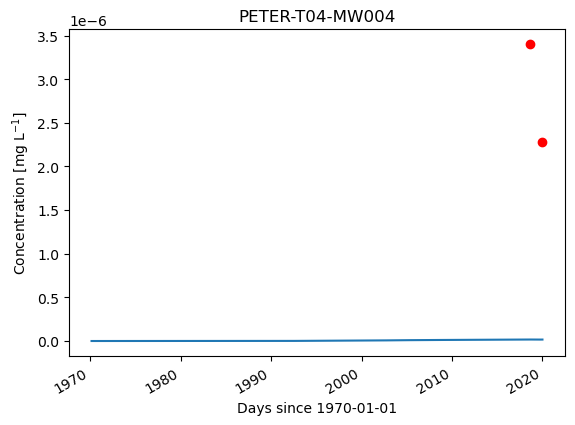

In [13]:
fig, ax = plt.subplots()

convertible_indexes = pfos_wells.index[pfos_wells['PETER-T04-MW004'].apply(is_convertible_to_float)].to_numpy()
well = pfos_wells.loc[convertible_indexes, 'PETER-T04-MW004'].to_numpy('float64')

# Convert x-axis values (convertible_indexes) to datetime
start_date = datetime(1970, 1, 1)
date_indexes = [start_date + timedelta(days=int(x)) for x in convertible_indexes]

ax.scatter(observations_pfos.SDate, observations_pfos['PETER-T04-MW004'] * 1e-9, c='r')
ax.plot(date_indexes, well)#, label=column)
ax.set_ylabel('Concentration [mg L$^{-1}$]')
ax.set_xlabel('Days since 1970-01-01')

ax.set_title('PETER-T04-MW004')
# Format x-axis as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format the x-axis with dates
fig.autofmt_xdate()  # Rotate date labels for better readability

# ax.legend()
    
plt.show()

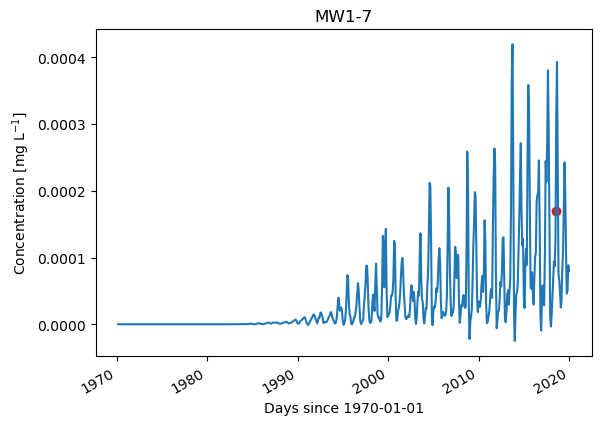

In [14]:
fig, ax = plt.subplots()

convertible_indexes = pfos_wells.index[pfos_wells['MW1-7'].apply(is_convertible_to_float)].to_numpy()
well = pfos_wells.loc[convertible_indexes, 'MW1-7'].to_numpy('float64')

# Convert x-axis values (convertible_indexes) to datetime
start_date = datetime(1970, 1, 1)
date_indexes = [start_date + timedelta(days=int(x)) for x in convertible_indexes]

ax.scatter(observations_pfos.SDate, observations_pfos['MW1-7'] * 1e-9, c='r')
ax.plot(date_indexes, well)#, label=column)
ax.set_ylabel('Concentration [mg L$^{-1}$]')
ax.set_xlabel('Days since 1970-01-01')

ax.set_title('MW1-7')

# Format x-axis as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format the x-axis with dates
fig.autofmt_xdate()  # Rotate date labels for better readability

# ax.legend()
    
plt.show()

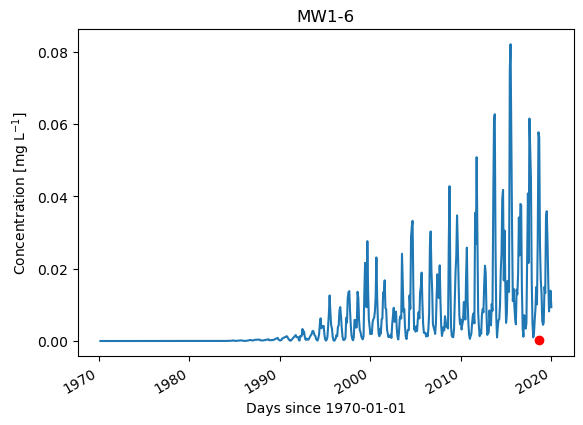

In [15]:
fig, ax = plt.subplots()

convertible_indexes = pfos_wells.index[pfos_wells['MW1-6'].apply(is_convertible_to_float)].to_numpy()
well = pfos_wells.loc[convertible_indexes, 'MW1-6'].to_numpy('float64')

# Convert x-axis values (convertible_indexes) to datetime
start_date = datetime(1970, 1, 1)
date_indexes = [start_date + timedelta(days=int(x)) for x in convertible_indexes]

ax.scatter(observations_pfos.SDate, observations_pfos['MW1-7'] * 1e-9, c='r')
ax.plot(date_indexes, well)#, label=column)
ax.set_ylabel('Concentration [mg L$^{-1}$]')
ax.set_xlabel('Days since 1970-01-01')

ax.set_title('MW1-6')

# Format x-axis as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format the x-axis with dates
fig.autofmt_xdate()  # Rotate date labels for better readability

# ax.legend()
    
plt.show()

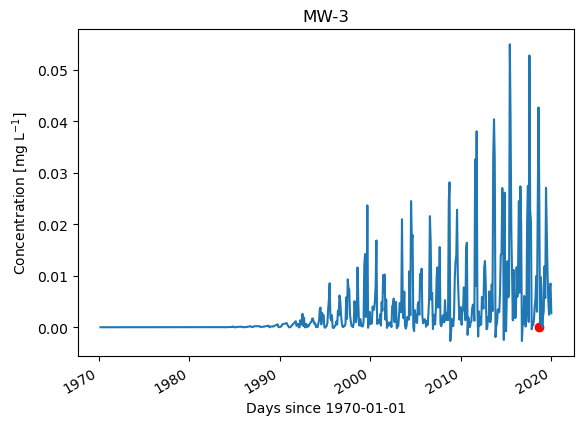

In [16]:
fig, ax = plt.subplots()

convertible_indexes = pfos_wells.index[pfos_wells['MW-3'].apply(is_convertible_to_float)].to_numpy()
well = pfos_wells.loc[convertible_indexes, 'MW-3'].to_numpy('float64')

# Convert x-axis values (convertible_indexes) to datetime
start_date = datetime(1970, 1, 1)
date_indexes = [start_date + timedelta(days=int(x)) for x in convertible_indexes]

ax.scatter(observations_pfos.SDate, observations_pfos['MW-3'] * 1e-9, c='r')
ax.plot(date_indexes, well)#, label=column)
ax.set_ylabel('Concentration [mg L$^{-1}$]')
ax.set_xlabel('Days since 1970-01-01')

ax.set_title('MW-3')

# Format x-axis as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format the x-axis with dates
fig.autofmt_xdate()  # Rotate date labels for better readability

# ax.legend()
    
plt.show()

KeyError: 'S17'

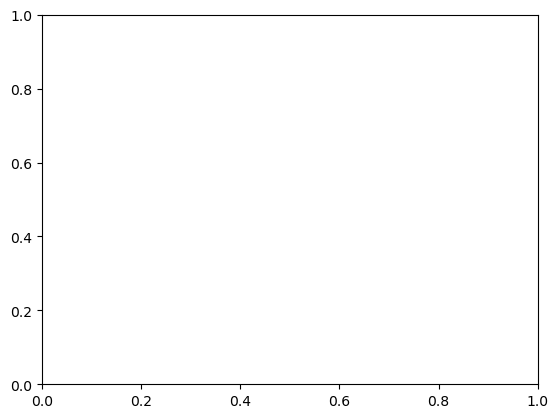

In [17]:
fig, ax = plt.subplots()

convertible_indexes = pfos_wells.index[pfos_wells['S17'].apply(is_convertible_to_float)].to_numpy()
well = pfos_wells.loc[convertible_indexes, 'S17'].to_numpy('float64')

# Convert x-axis values (convertible_indexes) to datetime
start_date = datetime(1970, 1, 1)
date_indexes = [start_date + timedelta(days=int(x)) for x in convertible_indexes]

ax.scatter(observations_pfos.SDate, observations_pfos['S17'] * 1e-9, c='r')
ax.plot(date_indexes, well)#, label=column)
ax.set_ylabel('Concentration [mg L$^{-1}$]')
ax.set_xlabel('Days since 1970-01-01')

ax.set_title('S17')

# Format x-axis as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format the x-axis with dates
fig.autofmt_xdate()  # Rotate date labels for better readability

# ax.legend()
    
plt.show()